In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('Control_191216.csv')

# Display the unique trackIDs in the dataset
unique_tracks = df['TrackID'].unique()
print("Available trackIDs:", unique_tracks)

# Choose one track (here, the first one is selected)
selected_track = unique_tracks[0]
trajectory = df[df['TrackID'] == selected_track]

print("Extracted trajectory for trackID =", selected_track)
print(trajectory)

# Optional: Plot the trajectory in 3D if x, y, z columns are available
if all(col in df.columns for col in ['x', 'y', 'z']):
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(trajectory['x'], trajectory['y'], trajectory['z'], marker='o', linestyle='-', color='green')
    ax.set_title(f'Trajectory for trackID {selected_track}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()


Available trackIDs: [1000000000 1000000001 1000000002 ... 1000268423 1000268426 1000268445]
Extracted trajectory for trackID = 1000000000
       Position X  Position Y  Position Z Unit  Time     TrackID      ID
0         86.3574     61.8013         0.5   um     1  1000000000       0
252       86.4880     61.9777         0.5   um     2  1000000000     252
509       86.2953     62.3200         0.5   um     3  1000000000  136803
776       85.9811     63.2709         0.5   um     4  1000000000  137070
1046      86.4232     63.4818         0.5   um     5  1000000000  137340
...           ...         ...         ...  ...   ...         ...     ...
20455     98.2762     61.7592         0.5   um    60  1000000000  156749
20818     97.5209     60.9451         0.5   um    61  1000000000  157112
21184     97.1474     60.4331         0.5   um    62  1000000000  157478
21549     97.4725     61.0465         0.5   um    63  1000000000  157843
21908     97.2675     61.3038         0.5   um    64  10000

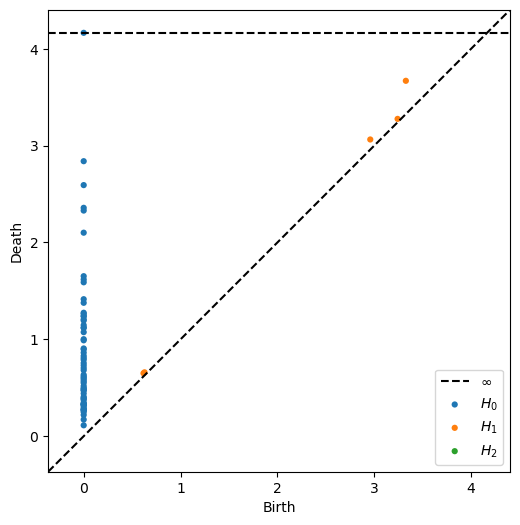

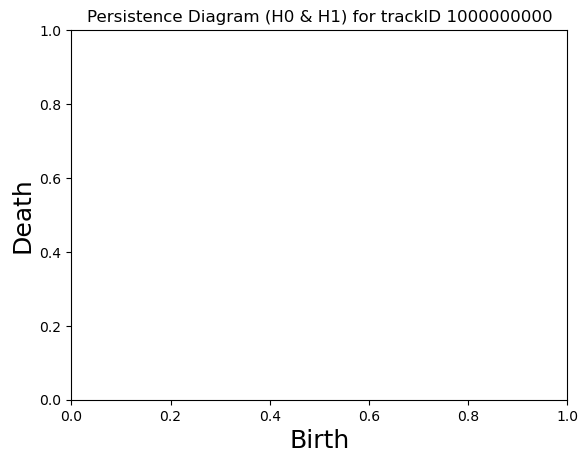

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from ripser import ripser
from persim import plot_diagrams

# 1. Load your data
df = pd.read_csv('Control_191216.csv')

# 2. Pick one trajectory (here: the first trackID)
track_id = df['TrackID'].unique()[0]
traj = df[df['TrackID'] == track_id][['Position X', 'Position Y', 'Position Z']].values

# 3. Compute persistence
#    ripser returns a dict with 'dgms' = list of arrays: [H0 diagram, H1 diagram, ...]
diagrams = ripser(traj, maxdim=2)['dgms']

# 4. Plot
plt.figure(figsize=(8, 6))
plot_diagrams(diagrams, show=True)
plt.title(f'Persistence Diagram (H0 & H1) for trackID {track_id}')
plt.xlabel('Birth',fontsize = 18)
plt.ylabel('Death',fontsize = 18)
plt.show()


In [1]:
import pandas as pd
import numpy as np
from scipy.spatial import distance_matrix

# Load the dataset
df = pd.read_csv('Control_270317_Autoregessive_Filtered.csv')

# Get unique trackIDs
track_ids = df['TrackID'].unique()

# List to store results
results = []

# Loop over each track
for tid in track_ids:
    traj = df[df['TrackID'] == tid][['Position X', 'Position Y', 'Position Z']].values
    n = traj.shape[0]
    if n < 3:
        # Not enough points to form loops
        results.append({'TrackID': tid, 'beta1': 0})
        continue

    # Compute pairwise distance matrix
    D = distance_matrix(traj, traj)
    nonzero = D[D > 0]
    epsilon = 0.5 * np.median(nonzero) if nonzero.size > 0 else 0

    # Build edges and triangles
    edges = [(i, j) for i in range(n) for j in range(i + 1, n) if D[i, j] <= epsilon]
    triangles = [
        (i, j, k)
        for i in range(n) for j in range(i + 1, n) for k in range(j + 1, n)
        if D[i, j] <= epsilon and D[i, k] <= epsilon and D[j, k] <= epsilon
    ]

    V = n
    E = len(edges)
    T = len(triangles)

    # Compute connected components via union-find
    parent = list(range(n))

    def find(i):
        while parent[i] != i:
            parent[i] = parent[parent[i]]
            i = parent[i]
        return i

    def union(i, j):
        ri, rj = find(i), find(j)
        if ri != rj:
            parent[rj] = ri

    for i, j in edges:
        union(i, j)

    components = len({find(i) for i in range(n)})
    C = components

    # Approximate Betti-1: β1 = C - V + E - T
    beta1 = C - V + E - T
    results.append({'TrackID': tid, 'beta1': beta1})

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Filter tracks with beta1 > 0
tracks_with_loops = results_df[results_df['beta1'] > 0]

# Display the tracks that have Betti_1 > 0
results_df_sorted = tracks_with_loops.sort_values('beta1', ascending=False).reset_index(drop=True)
results_df_sorted


,TrackID,beta1
0,1000245405,1
1,1000301780,1


In [11]:
import pandas as pd
from ripser import ripser

# 1. Load the data
df = pd.read_csv('Control_270317_Autoregessive_Filtered.csv')

# 2. Prepare to collect trackIDs with β1 > 0
tracks_with_holes = []

# 3. Loop over each trajectory
for track_id, group in df.groupby('TrackID'):
    # Extract the 3D points for this track
    pts = group[['Position X', 'Position Y', 'Position Z']].values
    
    # Skip short tracks
    if pts.shape[0] < 3:
        continue
    
    # 4. Compute persistence up to H1
    dgms = ripser(pts, maxdim=1)['dgms']
    H1 = dgms[1]  # H1 persistence diagram: array of [birth, death] pairs
    
    # 5. Count H1 features that persist (death > birth)
    num_loops = (H1[:,1] > H1[:,0]).sum()
    
    # 6. Record tracks with any H1 features
    if num_loops > 0:
        tracks_with_holes.append((track_id, num_loops))

# 7. Report results
print("Tracks with β1 > 0:")
for tid, b1 in tracks_with_holes:
    print(f"  TrackID {tid!r}: β1 = {b1}")


D:\anaconda\Lib\site-packages\ripser\ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
D:\anaconda\Lib\site-packages\ripser\ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
D:\anaconda\Lib\site-packages\ripser\ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
D:\anaconda\Lib\site-packages\ripser\ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
D:\anaconda\Lib\site-packages\ripser\ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a dist

Tracks with β1 > 0:
  TrackID 1000000001: β1 = 1
  TrackID 1000000002: β1 = 1
  TrackID 1000000006: β1 = 9
  TrackID 1000000013: β1 = 1
  TrackID 1000000014: β1 = 7
  TrackID 1000000015: β1 = 4
  TrackID 1000000018: β1 = 3
  TrackID 1000000021: β1 = 5
  TrackID 1000000041: β1 = 8
  TrackID 1000000057: β1 = 9
  TrackID 1000000058: β1 = 4
  TrackID 1000000061: β1 = 24
  TrackID 1000000063: β1 = 13
  TrackID 1000000065: β1 = 2
  TrackID 1000000076: β1 = 15
  TrackID 1000000115: β1 = 10
  TrackID 1000000117: β1 = 10
  TrackID 1000000120: β1 = 4
  TrackID 1000000121: β1 = 3
  TrackID 1000000123: β1 = 6
  TrackID 1000000124: β1 = 2
  TrackID 1000000130: β1 = 9
  TrackID 1000000131: β1 = 1
  TrackID 1000000133: β1 = 12
  TrackID 1000000134: β1 = 6
  TrackID 1000000135: β1 = 7
  TrackID 1000000136: β1 = 10
  TrackID 1000000138: β1 = 14
  TrackID 1000000139: β1 = 70
  TrackID 1000000141: β1 = 1
  TrackID 1000000143: β1 = 1
  TrackID 1000000148: β1 = 9
  TrackID 1000000149: β1 = 5
  TrackID 1000

D:\anaconda\Lib\site-packages\ripser\ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
D:\anaconda\Lib\site-packages\ripser\ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
D:\anaconda\Lib\site-packages\ripser\ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
D:\anaconda\Lib\site-packages\ripser\ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
D:\anaconda\Lib\site-packages\ripser\ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a dist

In [22]:
import pandas as pd
from ripser import ripser

# 1. Load the data
df = pd.read_csv('Control_191216.csv')

# 2. Initialize counters
total_tracks = 0
tracks_with_hole = 0

# 3. Loop over each trajectory
for track_id, group in df.groupby('TrackID'):
    pts = group[['Position X', 'Position Y', 'Position Z']].values
    total_tracks += 1
    
    # Skip tracks too short to have loops
    if pts.shape[0] < 3:
        continue
    
    # Compute persistent homology up to dimension 1
    diagrams = ripser(pts, maxdim=1)['dgms']
    H1 = diagrams[1]  # H1 diagram
    
    # Count genuine H1 features (death > birth)
    if (H1[:,1] > H1[:,0]).any():
        tracks_with_hole += 1

# 4. Compute percentage
percentage = 100 * tracks_with_hole / total_tracks if total_tracks > 0 else 0

# 5. Report
print(f"Total trajectories: {total_tracks}")
print(f"Trajectories with at least one hole: {tracks_with_hole}")
print(f"Percentage with at least one hole: {percentage:.2f}%")


Total trajectories: 2017
Trajectories with at least one hole: 1674
Percentage with at least one hole: 82.99%


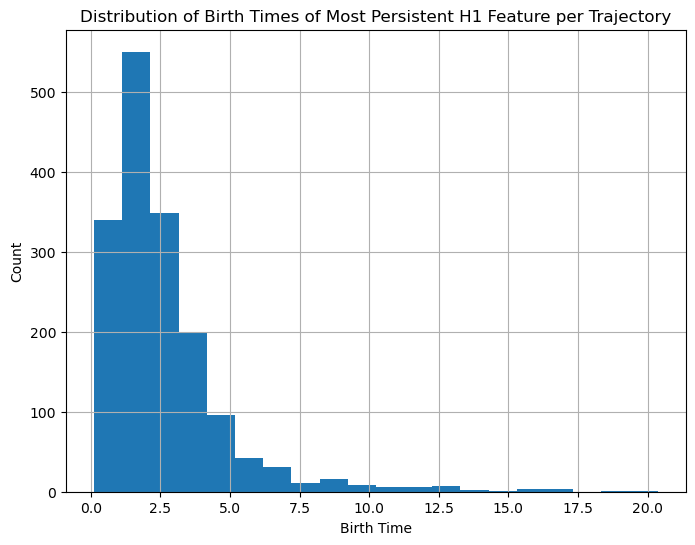

In [21]:
import pandas as pd
from ripser import ripser
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('Control_191216.csv')

# Collect birth times of the largest H1 feature per trajectory
birth_times = []
for track_id, group in df.groupby('TrackID'):
    # Extract 3D points
    pts = group[['Position X', 'Position Y', 'Position Z']].values
    # Skip tracks too short to form loops
    if pts.shape[0] < 3:
        continue
    # Compute persistence up to H1
    diags = ripser(pts, maxdim=1)['dgms'][1]
    # If no H1 features, skip
    if diags.size == 0:
        continue
    # Compute persistence (death - birth) and find the largest
    pers = diags[:, 1] - diags[:, 0]
    idx = np.argmax(pers)
    # Record the birth time of the most persistent loop
    birth_times.append(diags[idx, 0])

# Plot the distribution of these birth times
plt.figure(figsize=(8, 6))
plt.hist(birth_times, bins=20)
plt.title('Distribution of Birth Times of Most Persistent H1 Feature per Trajectory')
plt.xlabel('Birth Time')
plt.ylabel('Count')
plt.grid(True)
plt.show()


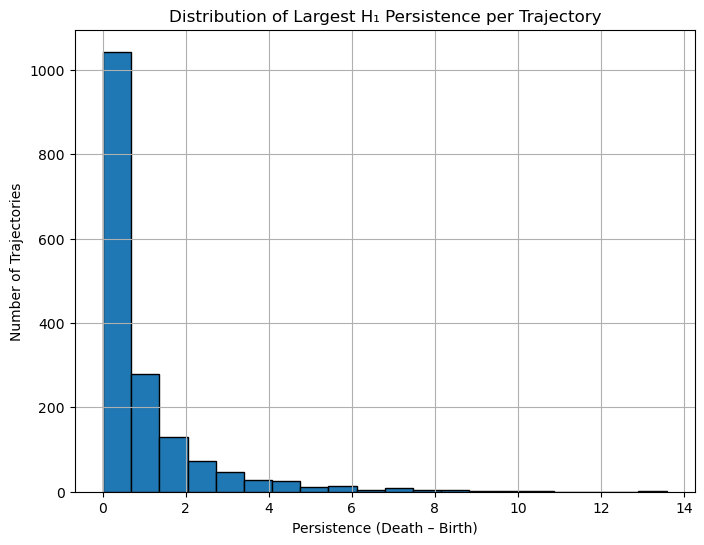

In [23]:
import pandas as pd
import numpy as np
from ripser import ripser
import matplotlib.pyplot as plt

# Load your data
df = pd.read_csv('Control_191216.csv')

# Collect the persistence (death−birth) of the largest H1 feature per trajectory
largest_persistences = []
for track_id, group in df.groupby('TrackID'):
    pts = group[['Position X', 'Position Y', 'Position Z']].values
    if pts.shape[0] < 3:
        continue
    # Compute persistence up to H1
    H1 = ripser(pts, maxdim=1)['dgms'][1]
    if H1.size == 0:
        continue
    # Compute persistence lifetimes and take the maximum
    pers = H1[:, 1] - H1[:, 0]
    largest_persistences.append(pers.max())

# Plot the histogram of these largest persistences
plt.figure(figsize=(8, 6))
plt.hist(largest_persistences, bins=20, edgecolor='black')
plt.title('Distribution of Largest H₁ Persistence per Trajectory')
plt.xlabel('Persistence (Death – Birth)')
plt.ylabel('Number of Trajectories')
plt.grid(True)
plt.show()


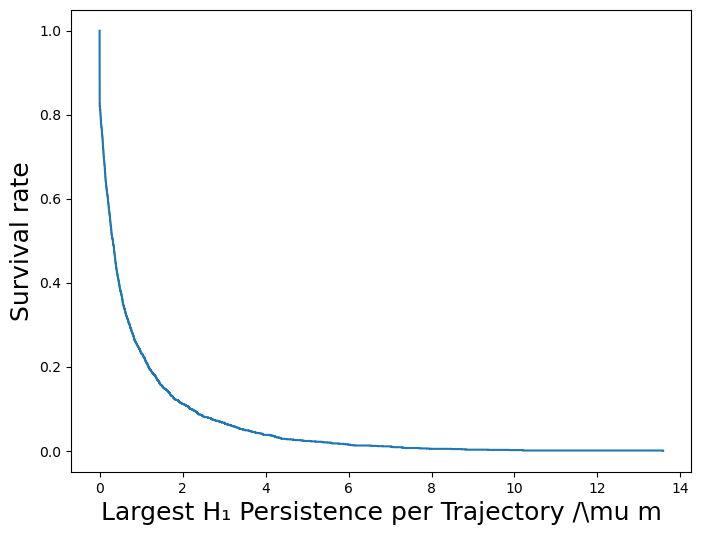

In [4]:
import pandas as pd
import numpy as np
from ripser import ripser
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('Control_191216.csv')

# Collect largest H1 persistence per trajectory
largest_pers = []
for track_id, group in df.groupby('TrackID'):
    pts = group[['Position X', 'Position Y', 'Position Z']].values
    if pts.shape[0] < 3:
        largest_pers.append(0.0)
        continue
    H1 = ripser(pts, maxdim=1)['dgms'][1]
    pers = H1[:, 1] - H1[:, 0]
    if pers.size > 0:
        largest_pers.append(np.max(pers))
    else:
        largest_pers.append(0.0)

largest_pers = np.array(largest_pers)

# Sort and compute CDF
sorted_pers = np.sort(largest_pers)
cdf = 1- np.arange(1, len(sorted_pers) + 1) / len(sorted_pers)

# Plot CDF
plt.figure(figsize=(8, 6))
plt.step(sorted_pers, cdf, where='post')
plt.xlabel('Largest H₁ Persistence per Trajectory /\mu m',fontsize = 18)
plt.ylabel('Survival rate',fontsize = 18)
plt.show()


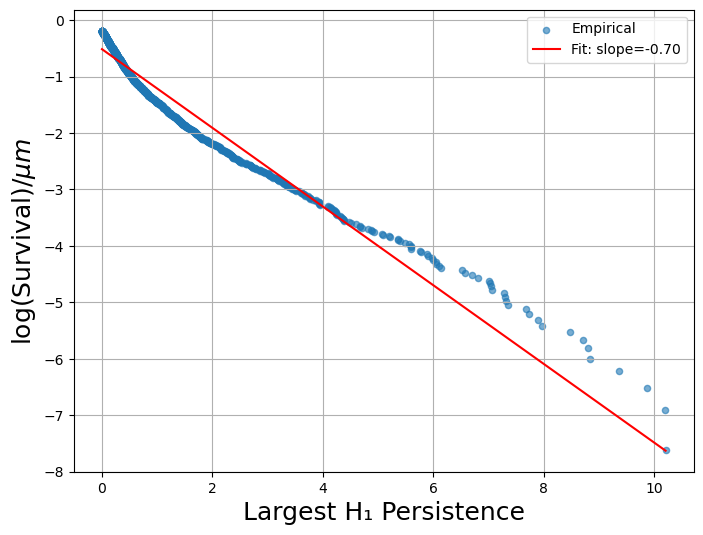

Power-law fit: log S = -0.51 + (-0.70) log t
Estimated exponent α = 0.70


In [10]:
import pandas as pd
import numpy as np
from ripser import ripser
import matplotlib.pyplot as plt
from scipy.stats import linregress

# 1. Load data and compute largest H1 persistence per trajectory
df = pd.read_csv('Control_191216.csv')
largest_pers = []
for _, group in df.groupby('TrackID'):
    pts = group[['Position X', 'Position Y', 'Position Z']].values
    if pts.shape[0] < 3:
        largest_pers.append(0.0)
        continue
    dgm1 = ripser(pts, maxdim=1)['dgms'][1]
    pers = dgm1[:,1] - dgm1[:,0]
    largest_pers.append(pers.max() if pers.size else 0.0)
largest_pers = np.array(largest_pers)

# 2. Compute empirical survival function
sorted_p = np.sort(largest_pers)
survival = 1 - np.arange(1, len(sorted_p)+1) / len(sorted_p)

# 3. Prepare log-log data, excluding zero or tiny values
mask = (sorted_p > 1e-3) & (survival > 0)
log_t = sorted_p[mask]
log_S = np.log(survival[mask])

# 4. Linear regression on log-log scale
slope, intercept, r_value, p_value, std_err = linregress(log_t, log_S)
alpha = -slope  # power-law exponent

# 5. Plot log-log survival and fitted line
plt.figure(figsize=(8,6))
plt.scatter(log_t, log_S, s=20, alpha=0.6, label='Empirical')
plt.plot(log_t, intercept + slope * log_t, 'r-', label=f'Fit: slope={slope:.2f}')
plt.xlabel('Largest H₁ Persistence',fontsize=18)
plt.ylabel('log(Survival)/$\mu m$',fontsize=18)
plt.legend()
plt.grid(True)
plt.show()

# 6. Print fit results
print(f"Power-law fit: log S = {intercept:.2f} + ({slope:.2f}) log t")
print(f"Estimated exponent α = {alpha:.2f}")


Selected TrackID = 1000000000, n_points = 64


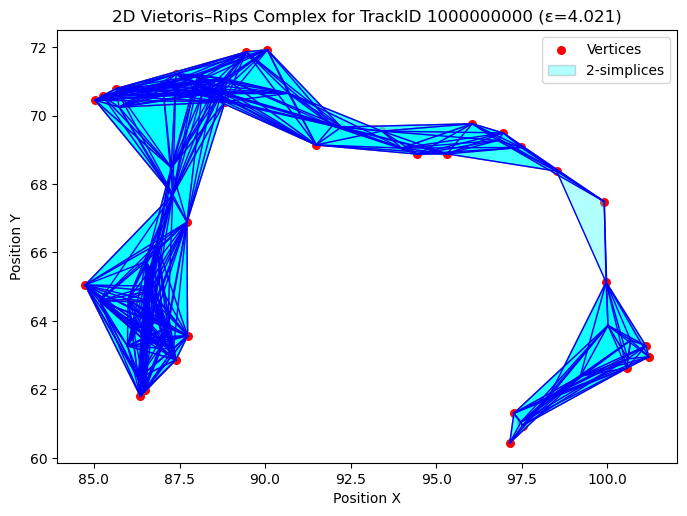

In [18]:
import pandas as pd
import numpy as np
from ripser import ripser
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection

# 1. Load the data
df = pd.read_csv('Control_191216.csv')

# 2. Find one trajectory with β₁ > 0 using only X, Y
selected_track = None
selected_pts = None

for tid, group in df.groupby('TrackID'):
    pts2d = group[['Position X', 'Position Y']].values
    if pts2d.shape[0] < 3:
        continue
    # compute H1 diagram in 2D
    H1 = ripser(pts2d, maxdim=1)['dgms'][1]
    loops = H1[H1[:,1] > H1[:,0]]  # genuine loops
    if loops.size > 0:
        selected_track = tid
        selected_pts = pts2d
        break

if selected_track is None:
    raise RuntimeError("No trajectory with β₁ > 0 found in 2D.")

print(f"Selected TrackID = {selected_track}, n_points = {selected_pts.shape[0]}")

# 3. Compute ε = ½·median(nonzero distances)
D = distance_matrix(selected_pts, selected_pts)
nonzero = D[D > 0]
epsilon = 0.5 * np.median(nonzero)

# 4. Build the Vietoris–Rips complex (vertices, edges, triangles)
n = selected_pts.shape[0]
edges = [(i, j) for i in range(n) for j in range(i+1, n) if D[i, j] <= epsilon]
triangles = [
    (i, j, k)
    for i in range(n) for j in range(i+1, n) for k in range(j+1, n)
    if D[i, j] <= epsilon and D[i, k] <= epsilon and D[j, k] <= epsilon
]

# 5. Plot the 2D complex
fig, ax = plt.subplots(figsize=(8, 8))

# Plot vertices
ax.scatter(selected_pts[:,0], selected_pts[:,1], color='red', s=30, label='Vertices')

# Plot edges
for i, j in edges:
    xs, ys = selected_pts[[i, j], 0], selected_pts[[i, j], 1]
    ax.plot(xs, ys, color='blue', linewidth=1)

# Plot triangles
if triangles:
    verts = [[selected_pts[i], selected_pts[j], selected_pts[k]] for i, j, k in triangles]
    poly = PolyCollection(verts, facecolors='cyan', edgecolors='gray', alpha=0.3, label='2-simplices')
    ax.add_collection(poly)

ax.set_title(f'2D Vietoris–Rips Complex for TrackID {selected_track} (ε={epsilon:.3f})')
ax.set_xlabel('Position X')
ax.set_ylabel('Position Y')
ax.legend()
ax.set_aspect('equal', 'box')
plt.show()


D:\anaconda\Lib\site-packages\ripser\ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
D:\anaconda\Lib\site-packages\ripser\ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
D:\anaconda\Lib\site-packages\ripser\ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
D:\anaconda\Lib\site-packages\ripser\ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
D:\anaconda\Lib\site-packages\ripser\ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a dist

Region 1 (0 ≤ t ≤ 4):
  slope = -1.081, intercept = -0.694, R² ≃ 0.979
Region 2 (4 < t ≤ 10):
  slope = -0.667, intercept = -1.612, R² ≃ 0.981


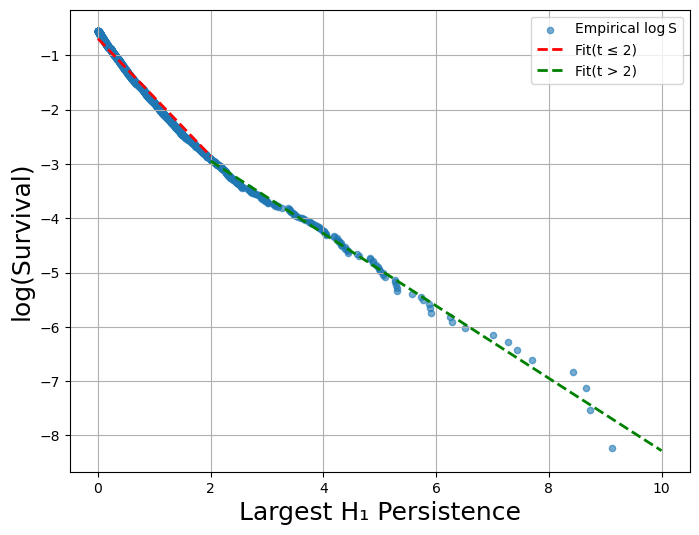

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ripser import ripser
from scipy.stats import linregress

# 1) Load data and compute largest H1 persistence per trajectory
df = pd.read_csv('Control_270317_Autoregessive_Filtered.csv')

largest_pers = []
for _, group in df.groupby('TrackID'):
    pts = group[['Position X','Position Y','Position Z']].values
    if pts.shape[0] < 3:
        largest_pers.append(0.0)
        continue
    dgm1 = ripser(pts, maxdim=1)['dgms'][1]
    pers = dgm1[:,1] - dgm1[:,0]
    largest_pers.append(pers.max() if pers.size else 0.0)

largest_pers = np.array(largest_pers)

# 2) Sort and compute survival function S(t) = 1 - CDF(t)
sorted_t = np.sort(largest_pers)
n = len(sorted_t)
survival = 1.0 - np.arange(1, n+1) / n

# 3) Compute log-survival, but we must drop any zero or extremely small survival values
#    and also drop zero persistence (so that log is defined)
eps = 1e-10
mask_nonzero = (sorted_t > 0) & (survival > eps)

t_vals = sorted_t[mask_nonzero]
logS_vals = np.log(survival[mask_nonzero])

# 4) Define the two regions: Region1: t ∈ [0,4], Region2: t ∈ (4,10]
mask1 = (t_vals <= 4.0)
mask2 = (t_vals > 4.0) & (t_vals <= 10.0)

t1 = t_vals[mask1]
logS1 = logS_vals[mask1]

t2 = t_vals[mask2]
logS2 = logS_vals[mask2]

# 5) Fit linear regression in each region: logS = a*t + b  ⇒ slope = a, intercept = b
slope1, intercept1, r1, p1, stderr1 = linregress(t1, logS1)
slope2, intercept2, r2, p2, stderr2 = linregress(t2, logS2)

print("Region 1 (0 ≤ t ≤ 4):")
print(f"  slope = {slope1:.3f}, intercept = {intercept1:.3f}, R² ≃ {r1**2:.3f}")

print("Region 2 (4 < t ≤ 10):")
print(f"  slope = {slope2:.3f}, intercept = {intercept2:.3f}, R² ≃ {r2**2:.3f}")

# 6) Plot empirical log‐survival and the two fitted lines
plt.figure(figsize=(8,6))
plt.scatter(t_vals, logS_vals, s=20, alpha=0.6, label='Empirical log S')

# Overplot the Region1 fit line
x1 = np.linspace(0, 2, 100)
y1 = intercept1 + slope1 * x1
plt.plot(x1, y1, 'r--', lw=2, label=f'Fit(t ≤ 2)')

# Overplot the Region2 fit line
x2 = np.linspace(2, 10, 100)
y2 = intercept2 + slope2 * x2
plt.plot(x2, y2, 'g--', lw=2, label=f'Fit(t > 2)')

plt.xlabel('Largest H₁ Persistence',fontsize = 18)
plt.ylabel('log(Survival)',fontsize = 18)
plt.legend()
plt.grid(True)
plt.show()


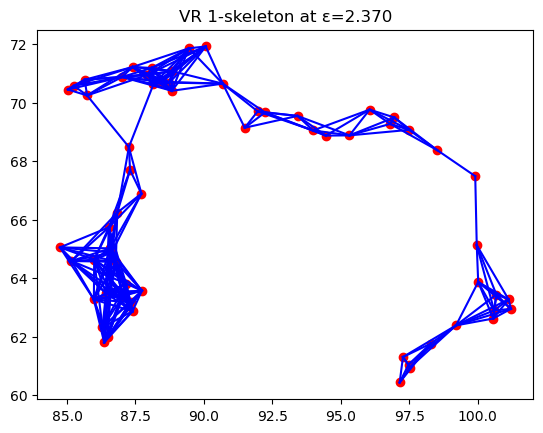

In [19]:
import numpy as np
import pandas as pd
from ripser import ripser
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection

# load & extract your chosen track pts2d
df        = pd.read_csv('Control_191216.csv')
pts2d     = df[df.TrackID==selected_track][['Position X','Position Y']].values

# compute persistence and pick the largest loop
diags     = ripser(pts2d, maxdim=1)['dgms'][1]
pers      = diags[:,1] - diags[:,0]
birth, death = diags[np.argmax(pers)]

# set ε in the middle of the loop’s life
epsilon   = (birth + death)/2

# build edges (and triangles if you like)
D         = distance_matrix(pts2d, pts2d)
edges     = [(i,j) for i in range(len(pts2d)) for j in range(i+1,len(pts2d))
             if D[i,j] <= epsilon]

# plot just vertices + edges
fig, ax = plt.subplots()
ax.scatter(pts2d[:,0], pts2d[:,1], color='red')
for i,j in edges:
    ax.plot(pts2d[[i,j],0], pts2d[[i,j],1], color='blue')
ax.set_title(f'VR 1-skeleton at ε={(epsilon):.3f}')
plt.show()


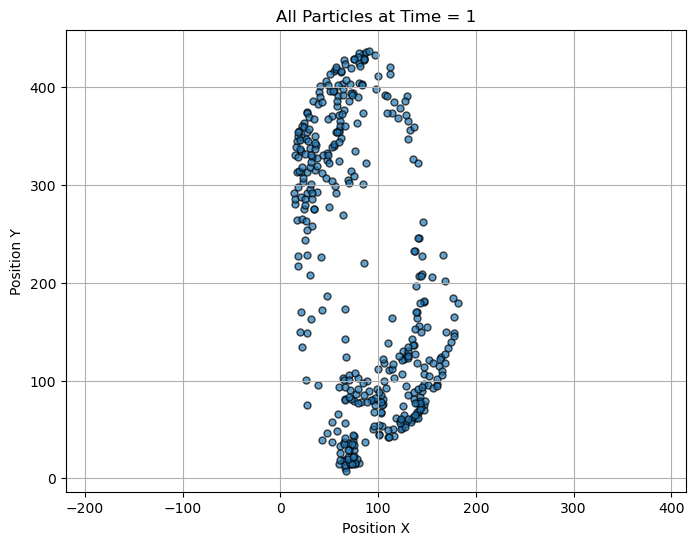

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data
df = pd.read_csv('Control_270317_Autoregessive_Filtered.csv')

# Filter to time = 1
# (if your column is lowercase, change 'Time' → 'time')
df_t1 = df[df['Time'] == 1]

# Make the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df_t1['Position X'], df_t1['Position Y'], s=25, alpha=0.7, edgecolor='k')
plt.title('All Particles at Time = 1')
plt.xlabel('Position X')
plt.ylabel('Position Y')
plt.grid(True)
plt.axis('equal')
plt.show()


In [24]:
pts2d = df[df.TrackID==selected_track][['Position X','Position Y']]
print("Number of detections for TrackID", selected_track, ":", len(pts2d))


Number of detections for TrackID 1000000000 : 64


Selected TrackID = 1000176777 with largest H1 persistence = 14.628
  birth = 3.483, death = 18.111


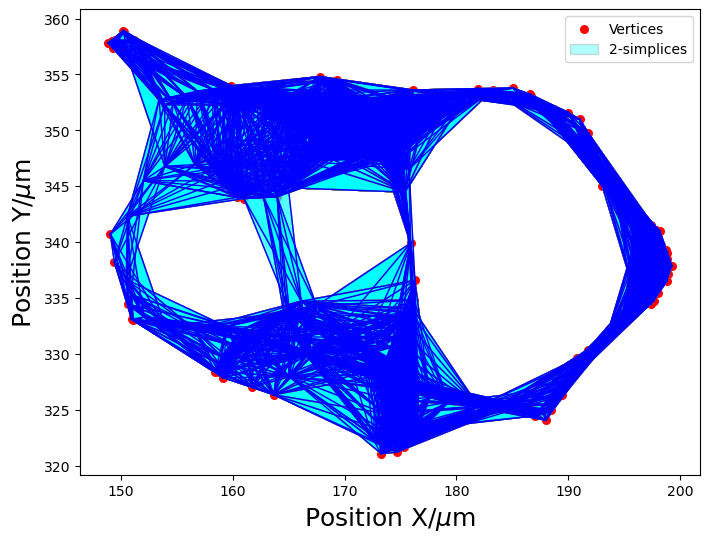

In [15]:
import pandas as pd
import numpy as np
from ripser import ripser
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection

# 1. Load data
df = pd.read_csv('Control_191216.csv')

# 2. Find the track & feature with the largest H1 persistence
best = {'track': None, 'birth': 0, 'death': 0, 'persistence': 0}

for tid, group in df.groupby('TrackID'):
    pts = group[['Position X','Position Y']].values
    if pts.shape[0] < 3:
        continue

    # compute H1 diagram
    H1 = ripser(pts, maxdim=1)['dgms'][1]  
    if H1.size == 0:
        continue

    # compute persistence lifetimes
    pers = H1[:,1] - H1[:,0]
    idx = np.argmax(pers)
    if pers[idx] > best['persistence']:
        best.update({
            'track': tid,
            'birth': H1[idx,0],
            'death': H1[idx,1],
            'persistence': pers[idx],
            'pts': pts
        })

if best['track'] is None:
    raise RuntimeError("No loop found in any trajectory.")

print(f"Selected TrackID = {best['track']} with largest H1 persistence = {best['persistence']:.3f}")
print(f"  birth = {best['birth']:.3f}, death = {best['death']:.3f}")

# 3. Choose epsilon in the middle of that feature’s lifetime
epsilon = 0.5*(best['birth'] + best['death'])
pts2d   = best['pts']
n       = pts2d.shape[0]

# 4. Build VR complex at ε
D = distance_matrix(pts2d, pts2d)
edges = [(i,j) for i in range(n) for j in range(i+1,n) if D[i,j] <= epsilon]
triangles = [
    (i,j,k) 
    for i in range(n) for j in range(i+1,n) for k in range(j+1,n)
    if D[i,j] <= epsilon and D[i,k] <= epsilon and D[j,k] <= epsilon
]

# 5. Plot
fig, ax = plt.subplots(figsize=(8,8))

# vertices
ax.scatter(pts2d[:,0], pts2d[:,1], color='red', s=30, label='Vertices')

# edges
for i,j in edges:
    ax.plot(pts2d[[i,j],0], pts2d[[i,j],1], color='blue', linewidth=1)

# filled triangles
if triangles:
    verts = [[pts2d[i], pts2d[j], pts2d[k]] for (i,j,k) in triangles]
    poly = PolyCollection(verts, facecolors='cyan', edgecolors='gray', alpha=0.3, label='2-simplices')
    ax.add_collection(poly)

ax.set_xlabel('Position X/$\mu$m',fontsize = 18)
ax.set_ylabel('Position Y/$\mu$m', fontsize = 18)
ax.legend()
ax.set_aspect('equal', 'box')
plt.show()


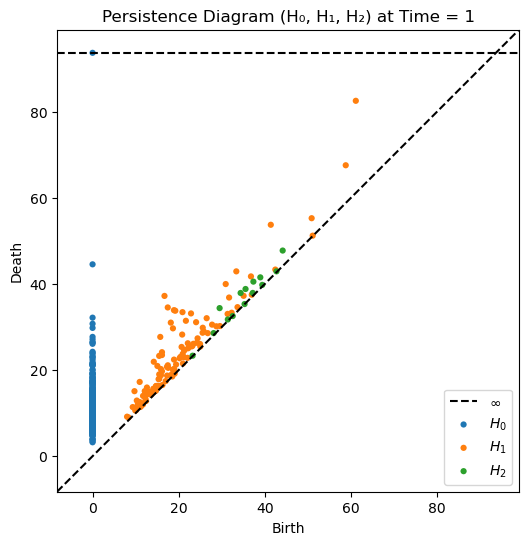

Selected TrackID = 1000176777 with persistence 14.628


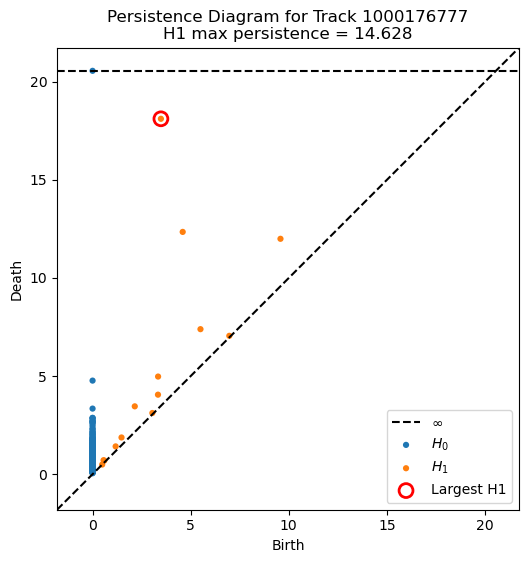

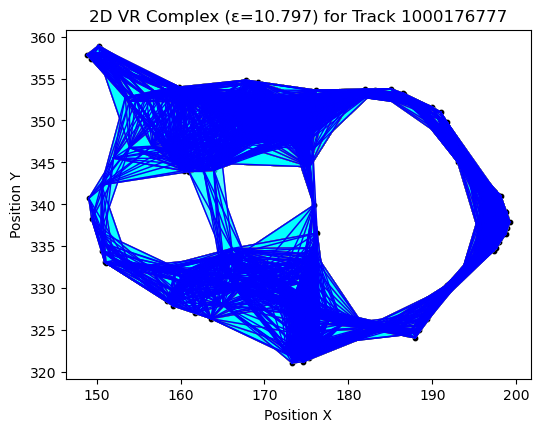

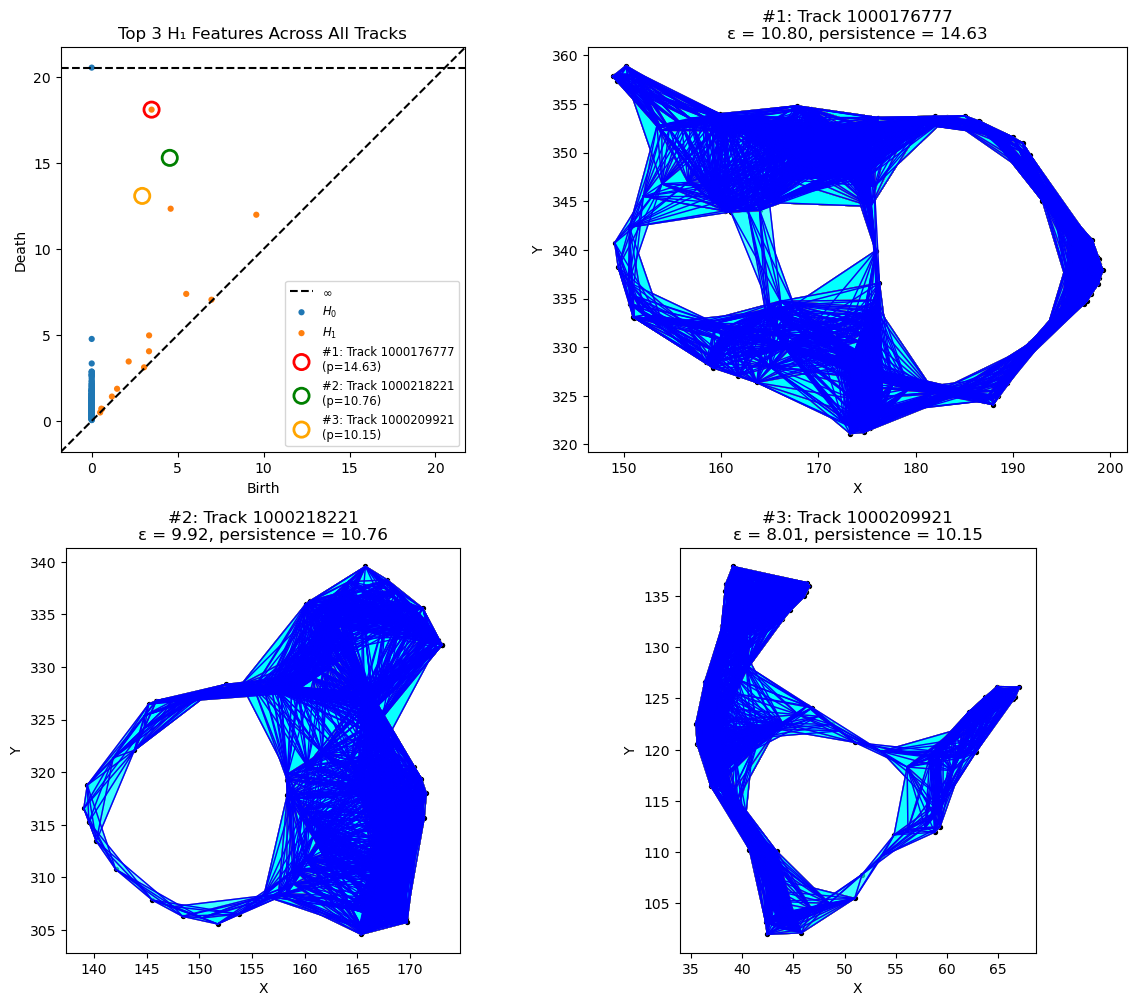

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ripser import ripser
from persim import plot_diagrams
from scipy.spatial import distance_matrix
from matplotlib.collections import PolyCollection

# 1. Load data
df = pd.read_csv('Control_191216.csv')

# 2. Scan all tracks, collect all H1 features
all_h1 = []  # will hold tuples (persistence, birth, death, track_id, pts2d)
for tid, group in df.groupby('TrackID'):
    pts2d = group[['Position X','Position Y']].values
    if len(pts2d) < 3:
        continue
    dgm = ripser(pts2d, maxdim=1)['dgms'][1]  # H1 only
    # keep only genuine loops
    loops = dgm[dgm[:,1] > dgm[:,0]]
    for birth, death in loops:
        all_h1.append((death - birth, birth, death, tid, pts2d))

if not all_h1:
    raise RuntimeError("No H1 features found.")

# 3. Pick top-3 by persistence
all_h1.sort(key=lambda x: x[0], reverse=True)
top3 = all_h1[:3]

# 4. Prepare a 2×2 figure
fig = plt.figure(figsize=(12,10))

# 4a. Persistence diagram in upper-left
ax_pd = fig.add_subplot(2,2,1)
# we’ll plot one representative trajectory’s full H0+H1 so axes are nicely scaled:
repr_pts = top3[0][4]
diags_repr = ripser(repr_pts, maxdim=1)['dgms']
plot_diagrams(diags_repr, ax=ax_pd, show=False)
colors = ['red','green','orange']
for i,(pers,birth,death,tid,pts) in enumerate(top3,1):
    ax_pd.scatter([birth],[death],
                  s=120, facecolors='none',
                  edgecolors=colors[i-1], linewidths=2,
                  label=f'#{i}: Track {tid}\n(p={pers:.2f})')
ax_pd.legend(loc='lower right', fontsize='small')
ax_pd.set_title("Top 3 H₁ Features Across All Tracks")

# 4b–4d. VR complexes at each εᵢ
for i,(pers,birth,death,tid,pts) in enumerate(top3,1):
    ε = 0.5*(birth+death)
    D = distance_matrix(pts, pts)
    # build edges & triangles
    n = len(pts)
    edges = [(u,v) for u in range(n) for v in range(u+1,n) if D[u,v] <= ε]
    tris  = [(u,v,w)
             for u in range(n) for v in range(u+1,n) for w in range(v+1,n)
             if D[u,v] <= ε and D[u,w] <= ε and D[v,w] <= ε]

    ax = fig.add_subplot(2,2,1+i)
    # raw points
    ax.scatter(pts[:,0], pts[:,1], c='black', s=8)
    # edges
    for u,v in edges:
        ax.plot(pts[[u,v],0], pts[[u,v],1], c='blue', lw=1)
    # triangles
    if tris:
        verts = [[pts[u],pts[v],pts[w]] for u,v,w in tris]
        ax.add_collection(PolyCollection(verts,
                                         facecolors='cyan',
                                         edgecolors='gray',
                                         alpha=0.3))
    ax.set_title(f'#{i}: Track {tid}\nε = {(ε):.2f}, persistence = {pers:.2f}')
    ax.set_aspect('equal')
    ax.set_xlabel('X'); ax.set_ylabel('Y')

plt.tight_layout()
plt.show()


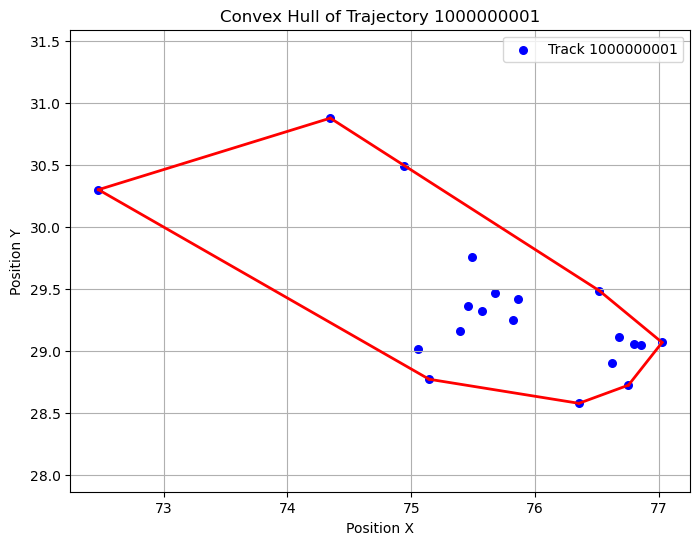

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

# 1. Load your data
df = pd.read_csv('Control_270317_Autoregessive_Filtered.csv')

# 2. Pick one trajectory (here: the first TrackID)
track_id = df['TrackID'].unique()[0]
traj = df[df['TrackID'] == track_id]

# 3. Extract the 2D points
pts = traj[['Position X', 'Position Y']].values

# 4. Compute the convex hull
hull = ConvexHull(pts)

# 5. Plot the points and hull
plt.figure(figsize=(8, 6))
plt.scatter(pts[:,0], pts[:,1], s=30, color='blue', label=f'Track {track_id}')

# draw hull edges
for simplex in hull.simplices:
    i, j = simplex
    plt.plot(pts[[i, j], 0], pts[[i, j], 1], 'r-', lw=2)

plt.title(f'Convex Hull of Trajectory {track_id}')
plt.xlabel('Position X')
plt.ylabel('Position Y')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()


Number of points at Time=1: 395


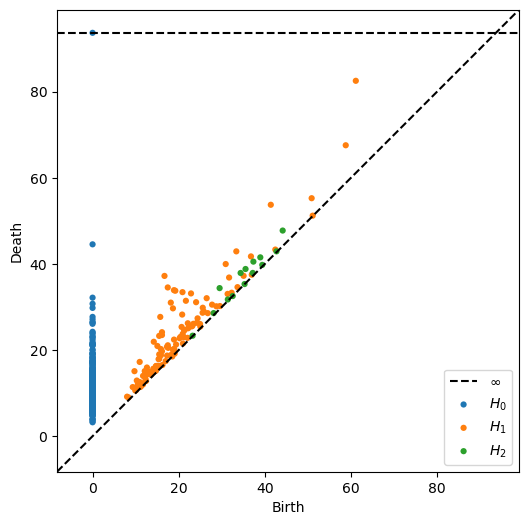

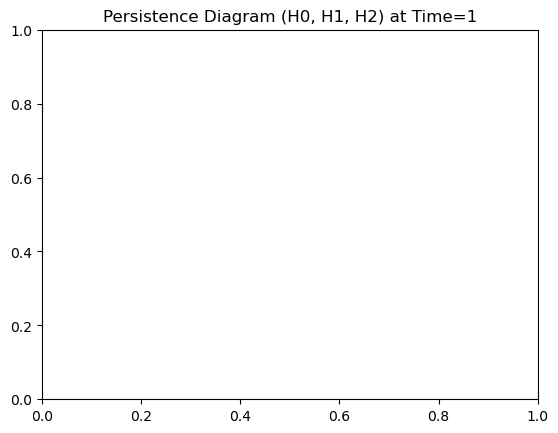

Largest H₂ feature (the central cavity):
  birth    = 29.4920
  death    = 34.3761
  persistence = 4.8841
  midpoint ε = 31.9341


In [16]:
import pandas as pd
import numpy as np
from ripser import ripser

# 1. Load the data
df = pd.read_csv('Control_270317_Autoregessive_Filtered.csv')

# 2. Initialize counters and storage
total_tracks = 0
tracks_with_large_hole = []
threshold = 1.0  # persistence threshold

# 3. Loop over each trajectory
for track_id, group in df.groupby('TrackID'):
    pts = group[['Position X', 'Position Y', 'Position Z']].values
    total_tracks += 1
    
    # Skip too-short tracks
    if pts.shape[0] < 3:
        continue
    
    # 4. Compute H1 persistence
    dgms = ripser(pts, maxdim=1)['dgms'][1]  # H1 diagram
    
    # 5. Check for any feature with persistence > threshold
    pers = dgms[:,1] - dgms[:,0]  # death - birth
    if np.any(pers > threshold):
        tracks_with_large_hole.append(track_id)

# 6. Calculate percentage
num_with = len(set(tracks_with_large_hole))
percent = 100 * num_with / total_tracks if total_tracks else 0

# 7. Report
print(f"Total number of trajectories: {total_tracks}")
print(f"Number with at least one H₁ feature of persistence > {threshold}: {num_with}")
print(f"Percentage: {percent:.2f}%")



D:\anaconda\Lib\site-packages\ripser\ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
D:\anaconda\Lib\site-packages\ripser\ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
D:\anaconda\Lib\site-packages\ripser\ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
D:\anaconda\Lib\site-packages\ripser\ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
D:\anaconda\Lib\site-packages\ripser\ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a dist

Total number of trajectories: 3722
Number with at least one H₁ feature of persistence > 1.0: 566
Percentage: 15.21%


D:\anaconda\Lib\site-packages\ripser\ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
D:\anaconda\Lib\site-packages\ripser\ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
D:\anaconda\Lib\site-packages\ripser\ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
D:\anaconda\Lib\site-packages\ripser\ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
D:\anaconda\Lib\site-packages\ripser\ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a dist

              file  total_tracks  tracks_with_hole>1   percent
Control_191216.csv          2017                 225 11.155181
Control_140117.csv          2052                 249 12.134503
Control_201216.csv          2726                 299 10.968452
  LanB1_270317.csv          4700                  64  1.361702
 LanB1_280317A.csv          4199                 133  3.167421
 LanB1_280317B.csv          4287                 130  3.032424
  LanB1_300317.csv          4191                 135  3.221188
   Scar_140117.csv          2875                  69  2.400000
   Scar_151216.csv          2233                  71  3.179579
   Scar_201216.csv          3284                  42  1.278928


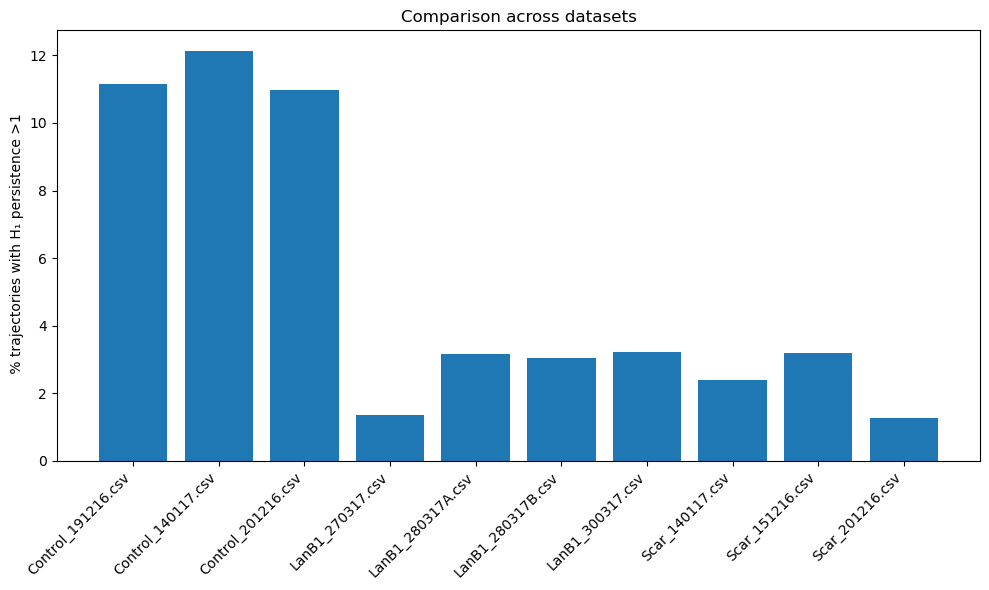

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ripser import ripser

# List of files to process
files = [
    "Control_191216.csv",
    "Control_140117.csv",
    "Control_201216.csv",
    "LanB1_270317.csv",
    "LanB1_280317A.csv",
    "LanB1_280317B.csv",
    "LanB1_300317.csv",
    "Scar_140117.csv",
    "Scar_151216.csv",
    "Scar_201216.csv",
]

results = []

for fname in files:
    df = pd.read_csv(fname)
    total = 0
    with_hole = 0
    
    for tid, group in df.groupby('TrackID'):
        pts = group[['Position X','Position Y','Position Z']].values
        total += 1
        if pts.shape[0] < 3:
            continue
        H1 = ripser(pts, maxdim=1)['dgms'][1]
        pers = H1[:,1] - H1[:,0]
        if np.any(pers > 2.0):
            with_hole += 1
    
    pct = 100 * with_hole / total if total>0 else 0
    results.append({"file": fname, "total_tracks": total, 
                    "tracks_with_hole>1": with_hole, "percent": pct})

# Make a DataFrame and print
res_df = pd.DataFrame(results)
print(res_df.to_string(index=False))

# Optional: bar‐plot of percentages
plt.figure(figsize=(10,6))
plt.bar(res_df['file'], res_df['percent'])
plt.xticks(rotation=45, ha='right')
plt.ylabel(' % trajectories with H₁ persistence >1')
plt.title('Comparison across datasets')
plt.tight_layout()
plt.show()


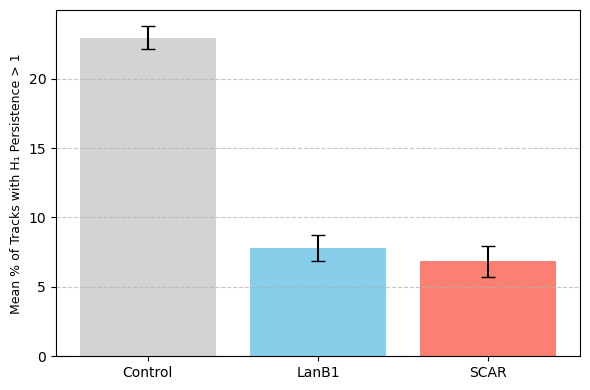

In [6]:
import pandas as pd
import numpy as np
from ripser import ripser
import matplotlib.pyplot as plt

# 1. Define your datasets by category
categories = {
    'Control': [
        'Control_201216.csv',
        'Control_191216.csv',
        'Control_140117.csv',
    ],
    'LanB1': [
        'LanB1_270317.csv',
        'LanB1_280317A.csv',
        'LanB1_280317B.csv',
        'LanB1_300317.csv',
    ],
    'SCAR': [
        'Scar_140117.csv',
        'Scar_151216.csv',
        'Scar_201216.csv',
    ]
}

threshold = 1.0  # persistence threshold

# 2. Compute percentage for each file
records = []
for cat, files in categories.items():
    for fname in files:
        df = pd.read_csv(fname)
        total = df['TrackID'].nunique()
        count = 0
        for tid, g in df.groupby('TrackID'):
            pts = g[['Position X','Position Y','Position Z']].values
            if pts.shape[0] < 3:
                continue
            H1 = ripser(pts, maxdim=1)['dgms'][1]
            pers = H1[:,1] - H1[:,0]
            if np.any(pers > threshold):
                count += 1
        pct = 100 * count / total if total>0 else np.nan
        records.append({'Category': cat, 'File': fname, 'Pct>1': pct})

df_pct = pd.DataFrame(records)

# 3. Compute group stats
summary = df_pct.groupby('Category')['Pct>1'] \
                .agg(['mean','std','count']) \
                .rename(columns={'mean':'MeanPct','std':'StdPct'})
summary['SEM'] = summary['StdPct'] / np.sqrt(summary['count'])

# 4. Plot
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(summary.index, summary['MeanPct'], 
       yerr=summary['SEM'], capsize=5,
       color=['lightgray','skyblue','salmon'])
ax.set_ylabel('Mean % of Tracks with H₁ Persistence > 1',fontsize = 9)
ax.grid(axis='y', ls='--', alpha=0.7)
plt.tight_layout()
plt.show()


Summary of Trajectory Lengths per Dataset


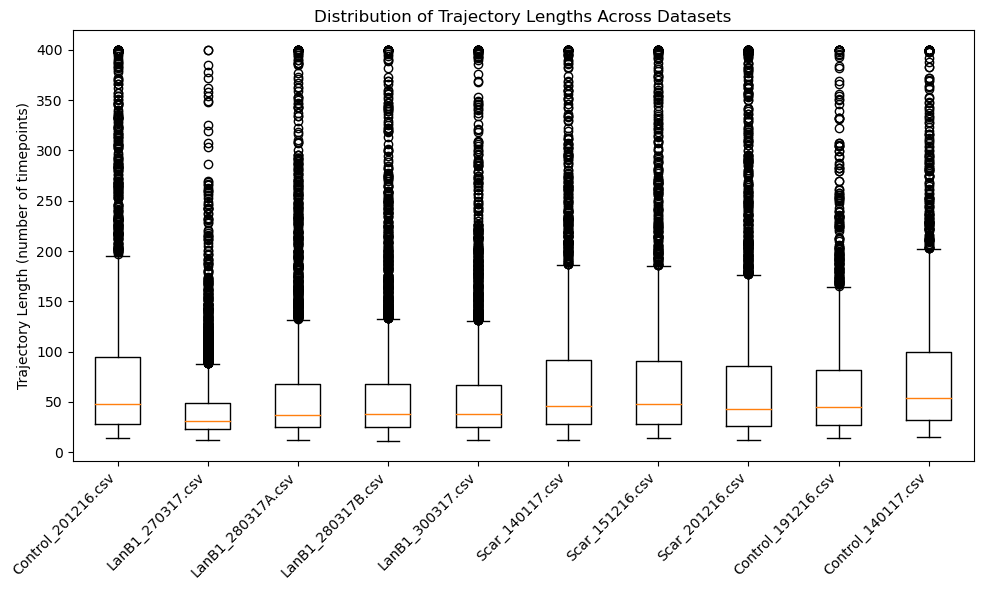

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import ace_tools_open as tools

# List of files
files = [
    "Control_201216.csv",
    "LanB1_270317.csv",
    "LanB1_280317A.csv",
    "LanB1_280317B.csv",
    "LanB1_300317.csv",
    "Scar_140117.csv",
    "Scar_151216.csv",
    "Scar_201216.csv",
    "Control_191216.csv",
    "Control_140117.csv",
]

# Compute trajectory lengths per TrackID for each file
lengths_dict = {}
for fname in files:
    df = pd.read_csv(fname)
    lengths = df.groupby('TrackID').size()
    lengths_dict[fname] = lengths.values

# Create a DataFrame of summary statistics
lengths_df = pd.DataFrame(dict((k, pd.Series(v)) for k, v in lengths_dict.items()))
summary = lengths_df.describe().loc[['mean', '50%', 'std']].rename(index={'50%': 'median'})

# Display summary statistics to the user
tools.display_dataframe_to_user(name="Summary of Trajectory Lengths per Dataset", dataframe=summary)

# Plot boxplot of trajectory lengths distributions
plt.figure(figsize=(10, 6))
plt.boxplot([lengths_df[f].dropna() for f in files], labels=files, vert=True)
plt.ylabel('Trajectory Length', fontsize = 18)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Summary of Trajectory Lengths per Dataset


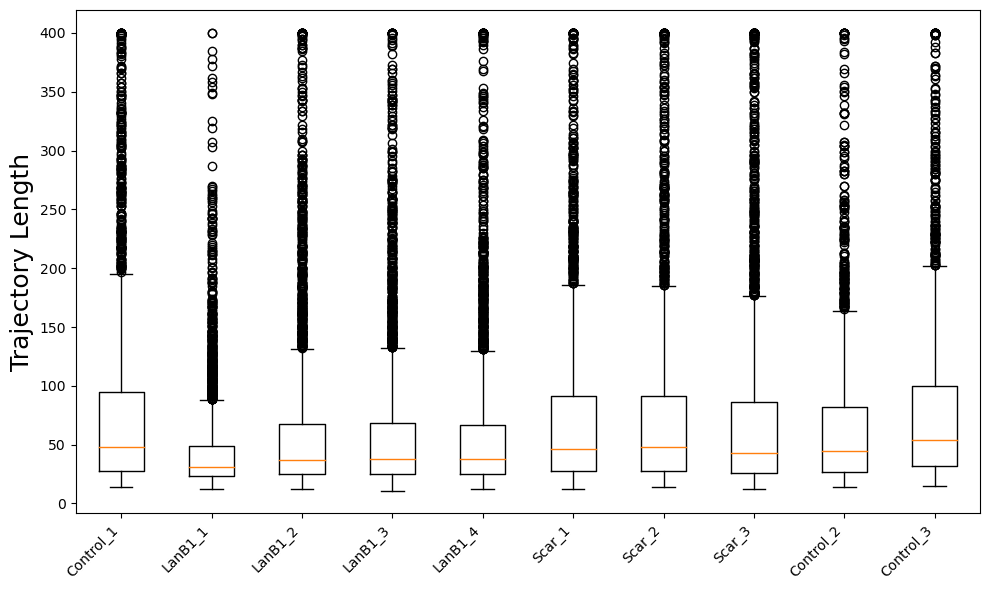

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import ace_tools_open as tools
from collections import defaultdict

# List of files
files = [
    "Control_201216.csv",
    "LanB1_270317.csv",
    "LanB1_280317A.csv",
    "LanB1_280317B.csv",
    "LanB1_300317.csv",
    "Scar_140117.csv",
    "Scar_151216.csv",
    "Scar_201216.csv",
    "Control_191216.csv",
    "Control_140117.csv",
]

# Compute trajectory lengths per TrackID for each file
lengths_dict = {}
for fname in files:
    df = pd.read_csv(fname)
    lengths = df.groupby('TrackID').size()
    lengths_dict[fname] = lengths.values

# Create a DataFrame of summary statistics
lengths_df = pd.DataFrame({k: pd.Series(v) for k, v in lengths_dict.items()})
summary = lengths_df.describe().loc[['mean', '50%', 'std']].rename(index={'50%': 'median'})

# Display summary statistics to the user
tools.display_dataframe_to_user(
    name="Summary of Trajectory Lengths per Dataset",
    dataframe=summary
)

# Generate nice labels like Control_1, Control_2, LanB1_1, etc.
counts = defaultdict(int)
labels = []
for fname in files:
    prefix = fname.split('_')[0]   # e.g. "Control", "LanB1", "Scar"
    counts[prefix] += 1
    labels.append(f"{prefix}_{counts[prefix]}")

# Plot boxplot of trajectory lengths distributions
plt.figure(figsize=(10, 6))
plt.boxplot(
    [lengths_df[fname].dropna() for fname in files],
    labels=labels,
    vert=True
)
plt.ylabel('Trajectory Length', fontsize=18)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


D:\anaconda\Lib\site-packages\ripser\ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
D:\anaconda\Lib\site-packages\ripser\ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
D:\anaconda\Lib\site-packages\ripser\ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
D:\anaconda\Lib\site-packages\ripser\ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
D:\anaconda\Lib\site-packages\ripser\ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a dist

Pearson correlation between length and Betti-1: 0.919


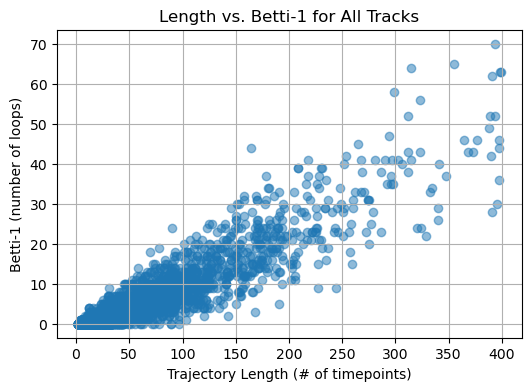

In [12]:
import pandas as pd

df = pd.read_csv('Control_270317_Autoregessive_Filtered.csv')  # or whichever file
lengths = df.groupby('TrackID').size().rename('length')  # number of timepoints per track
from ripser import ripser
import numpy as np

betti1 = {}
for tid, group in df.groupby('TrackID'):
    pts = group[['Position X','Position Y','Position Z']].values
    if pts.shape[0] < 3:
        betti1[tid] = 0
    else:
        dgm1 = ripser(pts, maxdim=1)['dgms'][1]   # H₁ diagram
        # Count features with (death > birth) as genuine loops
        b1_count = np.sum(dgm1[:,1] > dgm1[:,0])
        betti1[tid] = int(b1_count)

betti1 = pd.Series(betti1, name='betti1')
stats = pd.concat([lengths, betti1], axis=1).fillna(0)
corr = stats['length'].corr(stats['betti1'])
print(f"Pearson correlation between length and Betti-1: {corr:.3f}")
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.scatter(stats['length'], stats['betti1'], alpha=0.5)
plt.xlabel('Trajectory Length (# of timepoints)')
plt.ylabel('Betti-1 (number of loops)')
plt.title('Length vs. Betti-1 for All Tracks')
plt.grid(True)
plt.show()



Trajectory Length Statistics by File (95% CI for the mean):
                    n_tracks  mean_length  std_length   ci_lower   ci_upper
file                                                                       
Control_201216.csv      2726    79.593910   79.224275  76.619839  82.567982
LanB1_270317.csv        4700    43.907021   38.100131  42.817756  44.996286
LanB1_280317A.csv       4199    60.389855   62.195007  58.508639  62.271071
LanB1_280317B.csv       4287    59.314906   58.333336  57.568697  61.061114
LanB1_300317.csv        4191    59.224529   60.341672  57.397630  61.051428
Scar_140117.csv         2875    76.145391   77.078513  73.327849  78.962934
Scar_151216.csv         2233    78.554411   79.850801  75.242406  81.866416
Scar_201216.csv         3284    74.804507   79.970773  72.069327  77.539686
Control_191216.csv      2017    68.549331   64.931731  65.715590  71.383071
Control_140117.csv      2052    81.128655   75.385581  77.866867  84.390443
Control_130117.csv      664

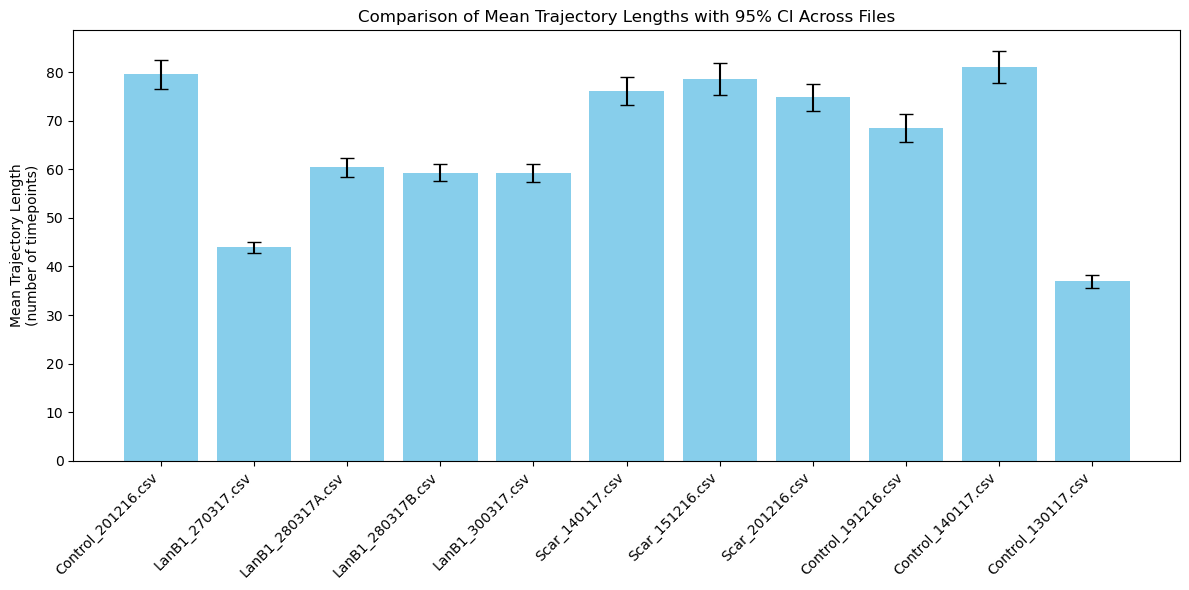

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. List of files to compare
files = [
    "Control_201216.csv",
    "LanB1_270317.csv",
    "LanB1_280317A.csv",
    "LanB1_280317B.csv",
    "LanB1_300317.csv",
    "Scar_140117.csv",
    "Scar_151216.csv",
    "Scar_201216.csv",
    "Control_191216.csv",
    "Control_140117.csv",
    "Control_130117.csv"
]

# 2. Collect trajectory lengths for each file
lengths_dict = {}
for fname in files:
    df = pd.read_csv(fname)
    # Count the number of timepoints per TrackID
    lengths = df.groupby("TrackID").size().values
    lengths_dict[fname] = lengths

# 3. Compute mean, standard deviation, and 95% CI for each file
stats_list = []
for fname, lengths in lengths_dict.items():
    n = len(lengths)
    mean_len = np.mean(lengths)
    std_len = np.std(lengths, ddof=1)
    sem = std_len / np.sqrt(n)                     # standard error of the mean
    ci95 = 1.96 * sem                              # 95% CI half-width
    stats_list.append({
        "file": fname,
        "n_tracks": n,
        "mean_length": mean_len,
        "std_length": std_len,
        "ci_lower": mean_len - ci95,
        "ci_upper": mean_len + ci95
    })

stats_df = pd.DataFrame(stats_list).set_index("file")

# 4. Print out the results
print("\nTrajectory Length Statistics by File (95% CI for the mean):")
print(stats_df)

# 5. Plot means with 95% CI error bars
plt.figure(figsize=(12, 6))
plt.bar(
    stats_df.index,
    stats_df["mean_length"],
    yerr=(stats_df["ci_upper"] - stats_df["mean_length"]),
    capsize=5,
    color='skyblue',
)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Mean Trajectory Length\n(number of timepoints)")
plt.title("Comparison of Mean Trajectory Lengths with 95% CI Across Files")
plt.tight_layout()
plt.show()


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import ace_tools as tools

# List of files
files = [
    "Control_201216.csv",
    "LanB1_270317.csv",
    "LanB1_280317A.csv",
    "LanB1_280317B.csv",
    "LanB1_300317.csv",
    "Scar_140117.csv",
    "Scar_151216.csv",
    "Scar_201216.csv",
    "Control_191216.csv",
    "Control_140117.csv",
]

# Compute trajectory lengths per TrackID for each file
lengths_dict = {}
for fname in files:
    df = pd.read_csv(fname)
    lengths = df.groupby('TrackID').size()
    lengths_dict[fname] = lengths.values

# Create a DataFrame of summary statistics
lengths_df = pd.DataFrame(dict((k, pd.Series(v)) for k, v in lengths_dict.items()))
summary = lengths_df.describe().loc[['mean', '50%', 'std']].rename(index={'50%': 'median'})

# Display summary statistics to the user
tools.display_dataframe_to_user(name="Summary of Trajectory Lengths per Dataset", dataframe=summary)

# Plot boxplot of trajectory lengths distributions
plt.figure(figsize=(10, 6))
plt.boxplot([lengths_df[f].dropna() for f in files], labels=files, vert=True)
plt.ylabel('Trajectory Length (number of timepoints)')
plt.title('Distribution of Trajectory Lengths Across Datasets')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'ace_tools'